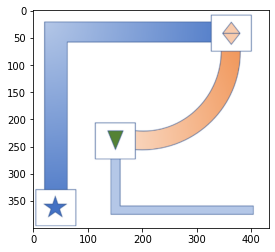

In [1]:
import cv2
import numpy as np
import math
import imutils
from matplotlib import pyplot as plt
def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
def cartesian_distance(x, y): return math.sqrt(x**2+y**2)

frame = cv2.imread("Picture1.png")
# frame = cv2.imread("Picture2.jpg")
frame = imutils.resize(frame, height=400)
imshow(frame)

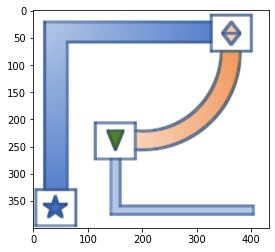

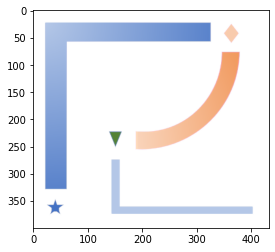

In [2]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
LUV = cv2.cvtColor(frame, cv2.COLOR_BGR2LUV)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(frame,kernel,iterations = 1)
dilation = cv2.dilate(frame,kernel,iterations = 1)
imshow(erosion)
imshow(dilation)

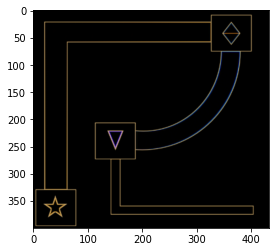

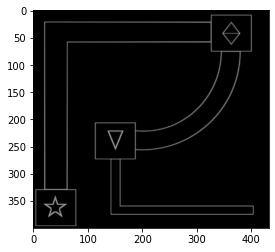

True

In [3]:
diff = cv2.absdiff(dilation, frame)
imshow(diff)
diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
imshow(diff)
cv2.imwrite("diff.jpg", diff)

In [4]:
def get_center(c):
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    rect = np.asarray(approx, dtype = "float32")
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (cX, cY)
def is_contour_rect(c):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # the contour is 'bad' if it is not a rectangle
    return len(approx) == 4
def is_contour_square(c):
    if not is_contour_rect(c): return False    
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    area = cv2.contourArea(approx)
    if area == 0: return False
    rect = cv2.boundingRect(approx)
    s_area = rect[2] * rect[3]
    return s_area/area > 0.9 and area/s_area > 0.9
def filter_contour_square(cnts):
    buffer = []
    for i, c in enumerate(cnts):
        if is_contour_square(c):
            dup = False
            for passed in buffer: # exclude duplicated rect
                if cv2.pointPolygonTest(passed, get_center(c), False) != -1: # Check if point inside contour
                    dup = True
            if not dup: buffer.append(np.array(c, dtype=np.int32))
    return buffer

Found 11 connected edges.


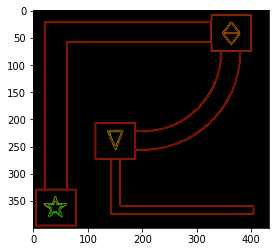

Found 40 contours.


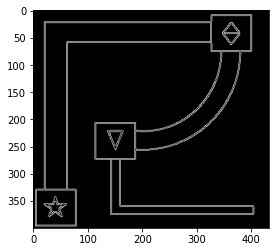

Found 3 rect contours.


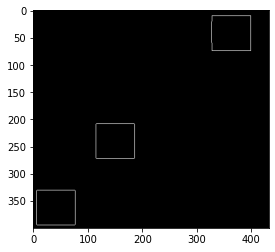

In [5]:
edges = cv2.Canny(diff, 20, 100)


## Find connected edges
ret, labels = cv2.connectedComponents(edges)
colors = [(0, 0, 255), (0, 43, 255), (0, 85, 255), (0, 128, 255), (0, 170, 255), (0, 213, 255), (0, 255, 255), (0, 255, 212), (0, 255, 170), (0, 255, 127), (0, 255, 85), (0, 255, 42), (0, 255, 0), (43, 255, 0), (85, 255, 0), (128, 255, 0), (170, 255, 0), (213, 255, 0), (255, 255, 0), (255, 212, 0), (255, 170, 0), (255, 127, 0), (255, 85, 0), (255, 42, 0), (255, 0, 0)]
## Draw(set to different colors)
canvas = np.zeros_like(frame, np.uint8)
for i in range(1,ret):
    pts = labels == i
    canvas[pts] = colors[i%len(colors)]
print("Found {} connected edges.".format(ret-1))
imshow(canvas)
    
contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # CHAIN_APPROX_NONE, CHAIN_APPROX_SIMPLE

black = np.zeros(frame.shape[:2], dtype="uint8") # For visualize all border
print("Found " + str(len(contours)) + " contours.")
for i in range(len(contours)): # Draw each contours
    cv2.drawContours(black, contours, i, 255, 1)
imshow(black)

## Filter only rect contours (Get marker) ##
cnts_sqrt = filter_contour_square(contours)
black = np.zeros(frame.shape[:2], dtype="uint8") # For visualize card border
print("Found " + str(len(cnts_sqrt)) + " rect contours.")
for i in range(len(cnts_sqrt)): # Draw each contours
    cv2.drawContours(black, cnts_sqrt, i, 255, 1)
imshow(black)

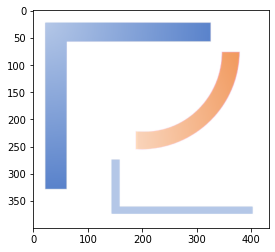

Found 3 path.


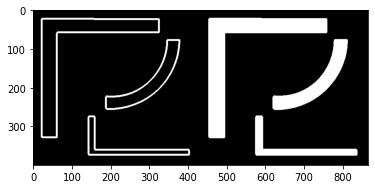

True

In [6]:
marker_mask = np.ones(frame.shape[:2], dtype="uint8") * 255 # For exclude marker
cv2.drawContours(marker_mask, cnts_sqrt, -1, 0, -1)


## Remove marker and fill with white
path_img = cv2.bitwise_and(dilation, dilation, mask=marker_mask)
path_img = cv2.fillPoly(path_img, cnts_sqrt, (255, 255, 255))
imshow(path_img)

## Find contour of path
edges_path = cv2.Canny(path_img, 20, 100)
cnts_path, hierarchy_path = cv2.findContours(edges_path,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print("Found {} path.".format(len(cnts_path)))

## Making path mask
black = np.zeros(frame.shape[:2], dtype="uint8")
cv2.drawContours(black, cnts_path, -1, 255, 3)
path_mask = np.zeros(frame.shape[:2], dtype="uint8") # For visualize
path_mask = cv2.fillPoly(black.copy(), cnts_path, 255)
imshow(np.hstack((black, path_mask)))
cv2.imwrite("path.png", path_mask)

In [7]:
class Card:
    def __init__(self, contours):
        self.contours = contours
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        self.rect = np.asarray(approx, dtype = "float32")
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        self.center = (cX, cY)
    def image(self, source):
        maxWidth, maxHeight = 50, 50
        dst = np.array([[0, 0], [0, maxHeight - 1], [maxWidth - 1, maxHeight - 1], [maxWidth - 1, 0]], dtype = "float32")
        M = cv2.getPerspectiveTransform(self.rect, dst)
        warped = cv2.warpPerspective(source, M, (maxWidth, maxHeight))
        return warped
class Path:
    def __init__(self, contours):
        self.contours = contours

[(41, 362), (150, 240), (363, 41)]


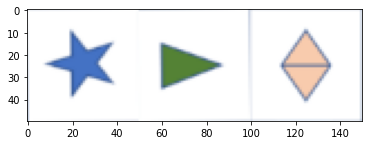

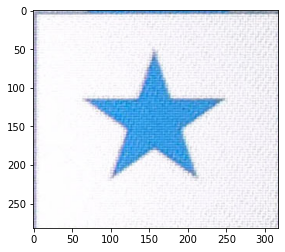

In [8]:
Cards = []
for c in cnts_sqrt: # Loop each card contour
    Cards.append(Card(c))
print([x.center for x in Cards])
imshow(np.hstack(tuple([x.image(frame) for x in Cards])))


## Define first marker ##
template = cv2.imread("Template1.jpg")
imshow(template)
similarity = []
for marker in Cards:
    pass

In [9]:
## Search for real path from cnts_path ##
